In [1]:
import numpy as np
import torch
from dataload import *
from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
dataset = dense_Dataset('data/embeddings.h5', 'data/densities.csv', test_perc=0.15, val_perc=0.15) 

In [3]:
train_keys, val_keys = dataset.train_keys, dataset.val_keys
train_loader = CNN_Dataloader(dataset, train_keys, batch_size=128, shuffle=True)
val_loader = CNN_Dataloader(dataset, val_keys, batch_size=128, shuffle=True)

In [5]:
hparams = {
    'epochs': 30,
    'lr':0.001,
    'patience': 5,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [6]:
model, losses_train, losses_val, outputs, targets = train_CNN(train_loader, val_loader, hparams)

starting training


D:\programming\PP1\.venv\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/30:   0%|          | 0/102 [00:00<?, ?it/s]D:\programming\PP1\dataload.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.tensor(self.embed_file[index], dtype=torch.float), torch.tensor(self.dense[index],
Epoch 1/30:   1%|          | 1/102 [00:06<11:28,  6.81s/it]D:\programming\PP1\.venv\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Tri

Best validation loss: 5.517795054604196e-05


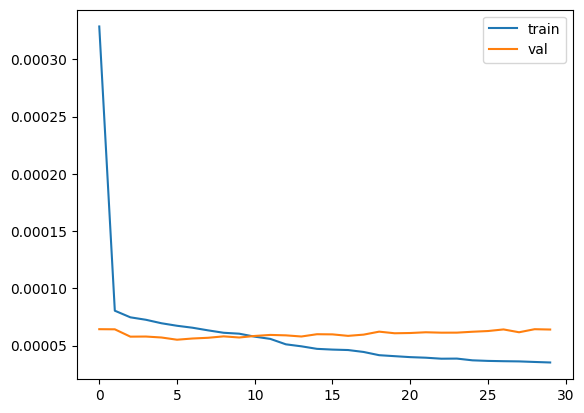

In [7]:
plt.plot(losses_train, label='train')
plt.plot(losses_val, label='val')
plt.legend()
plt.show()

In [8]:
# save cnn model
torch.save(model.state_dict(), 'models/cnn_model_0.001lr_30epochs_scheduler_3convs.pth')

MSE: 5.579791832133196e-05


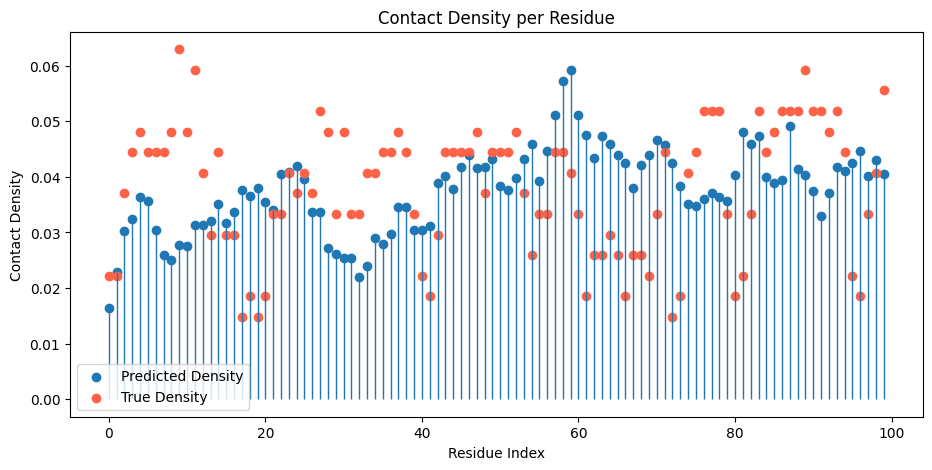

In [9]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()

# add mean to both predictions and truths
# truths = truths + target_mean.item()
# preds = preds + output_mean.item()
# clip predictions to 0
# preds = np.clip(preds, 0, None)

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:100]
preds = preds[:100]
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=0, ymax=preds)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.savefig("cnn_big_3convs.png")
plt.show()

In [10]:
# calculate mean of truths vs mean of preds
print(f"Mean of truths: {np.mean(truths)}, Mean of preds: {np.mean(preds)}")

Mean of truths: 0.037962961941957474, Mean of preds: 0.03768008574843407


In [ ]:
# shut down windows pc
# import os
# os.system("shutdown /s /t 1")


# OVERFIT ON ONE SAMPLE

In [26]:
overfit_hparams = {
    'epochs': 100,
    'lr':0.001,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [30]:
# overfit on one sample
overfit_train_loader = CNN_Dataloader(dataset, train_keys[:1], batch_size=128, shuffle=True)
overfit_val_loader = CNN_Dataloader(dataset, val_keys[:1], batch_size=128, shuffle=True)


In [31]:
model, losses_train, losses_val, outputs, targets = train_CNN(overfit_train_loader, overfit_val_loader, overfit_hparams)


starting training


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


MSE: 1.0915739494521404e-06


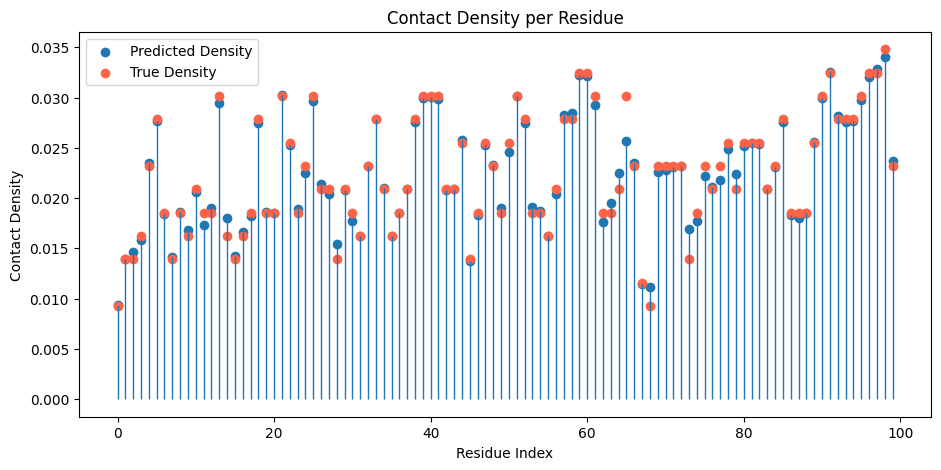

In [33]:
truths = targets.cpu().numpy()
preds = outputs.detach().cpu().numpy()

# add mean to both predictions and truths
# clip predictions to 0
# preds = np.clip(preds, 0, None)

# calculate MSE between predictions and truths
mse = np.mean((truths - preds) ** 2)
print(f"MSE: {mse}")

truths = truths[:100]
preds = preds[:100]
plt.figure(figsize=(11, 5))
plt.scatter(range(len(preds)), preds, label="Predicted Density")
plt.scatter(range(len(truths)), truths, c="tomato", label="True Density")
plt.vlines(x=range(len(preds)), linestyle='-', linewidth=1, ymin=0, ymax=preds)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.savefig("cnn_overfit.png")
plt.show()

# Test the model on the validation set

First we need to load the model from the state dict and then we can test it on the validation set.
Finally we can calculate the MSE between the predictions and the truths. As well as plot some results

In [11]:
model = load_model('models/cnn_model_0.001lr_30epochs_scheduler.pth', hparams)

In [11]:
val_loader = CNN_Dataloader(dataset, val_keys, batch_size=128, shuffle=True)

In [12]:
# test the model on the validation set
predictions = []
truths = []
keys = []
model.eval()
for inputs, targets, ids in val_loader:
    inputs, targets = inputs.to(hparams['device']), targets.to(hparams['device'])
    outputs = model(inputs)
    predictions.append(outputs.detach().cpu().numpy())
    truths.append(targets.cpu().numpy())
    keys.append(ids)


In [13]:
print(predictions[0].shape)
print(truths[0].shape)
print(len(keys[0]))

(128, 919)
(128, 919)
128


In [14]:
predictions = {'val_preds': predictions, 'val_truths': truths, 'val_ids': keys}
with open('predictions_cnn_3conv.pkl', 'wb') as f:
    pickle.dump(predictions, f)